In [1]:
import sys
sys.path.append('..')

import geopandas as gdp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 

from laos_gggi import load_shapefile, load_gpcc_data, load_emdat_data
from laos_gggi.const_vars import COUNTRIES_ISO, ISO_DICTIONARY

from libpysal.weights import Queen, KNN, fuzzy_contiguity, w_union, W
from esda.moran import Moran
import networkx as nx
import warnings
from itertools import zip_longest

# Load Data

In [2]:
precip_df = load_gpcc_data(repair_ISO_codes=True)
world = load_shapefile('world', repair_ISO_codes=True)
laos = load_shapefile('laos')
emdat_dict = load_emdat_data()

df_prob = emdat_dict["df_prob_filtered_adjusted"].drop(['Region', "Subregion"], axis=1)
df_inten = emdat_dict["df_inten_filtered_adjusted"].drop(['Region', 'Subregion'], axis=1)

## Reconsile EMDAT and shapefile ISO codes


In [3]:
world.set_index('ISO_A3', inplace=True)

In [4]:
emdat_iso = df_prob.index.get_level_values(0).unique()
world_iso = world.index.unique()

In [5]:
# Codes in EMDAT but not in world
# These are all historical:
", ".join(list(set(emdat_iso) - set(world_iso)))

'TKL, CSK, MYT, MTQ, TWN, YUG, SPI, YMD, REU, AZO, GLP, ANT, GUF, SUN, SCG, DFR, DDR, YMN'

From ChatGPT -- Check

- ANT - Netherlands Antilles (dissolved in 2010)
- YUG - Yugoslavia (dissolved in the early 1990s)
- DFR - German Democratic Republic (East Germany, merged with West Germany in 1990)
- CSK - Czechoslovakia (split into Czech Republic and Slovakia in 1993)
- DDR - German Democratic Republic (East Germany, same as DFR)
- SPI - Spain
- YMD - Yemen Democratic Republic (South Yemen, unified with North Yemen in 1990)
- TWN - Taiwan (Republic of China)
- SCG - Serbia and Montenegro (dissolved in 2006)
- MTQ - Martinique
- SUN - Soviet Union (dissolved in 1991)
- GUF - French Guiana
- REU - Réunion
- TKL - Tokelau
- YMN - Yemen (Republic of Yemen)
- AZO - Azores (part of Portugal)
- GLP - Guadeloupe

In [6]:
# Codes in shapefile but not in EMDAT
", ".join(list(set(world_iso) - set(emdat_iso)))

'SPM, PCN, VAT, NFK, FLK, AND, HMD, IOT, GRL, ABW, UNK, SMR, NRU, MCO, SGS, ATF, FRO, LIE, GIB, JEY, GGY'

From ChatGPT -- Check

- PCN - Pitcairn Islands
- NFK - Norfolk Island
- HMD - Heard Island and McDonald Islands
- ATF - French Southern and Antarctic Lands
- GGY - Guernsey
- AND - Andorra
- BHR - Bahrain
- VAT - Vatican City (Holy See)
- SPM - Saint Pierre and Miquelon
- FRO - Faroe Islands
- NRU - Nauru
- GRL - Greenland
- IOT - British Indian Ocean Territory
- JEY - Jersey
- FLK - Falkland Islands
- UNK - United Nations (used for various purposes)
- MCO - Monaco
- LIE - Liechtenstein
- SGP - Singapore
- CUW - Curaçao
- SMR - San Marino
- GNQ - Equatorial Guinea
- ABW - Aruba
- GIB - Gibraltar
- SGS - South Georgia and the South Sandwich Islands

## Drop codes not in both

In [7]:
common_codes = set(world_iso).intersection(set(emdat_iso))
df_prob = df_prob.loc[lambda x: x.index.get_level_values(0).isin(common_codes)].copy()
df_inten = df_inten.loc[lambda x: x.index.get_level_values(0).isin(common_codes)].copy()
world = world.loc[world.index.isin(common_codes)].copy()

## Get unique iso codes and years

In [8]:
code_idx, codes = pd.factorize(df_prob.index.get_level_values(0), sort=True)
year_idx, years = pd.factorize(df_prob.index.get_level_values(1), sort=True)
disasters = df_prob.columns.tolist()

# Maps

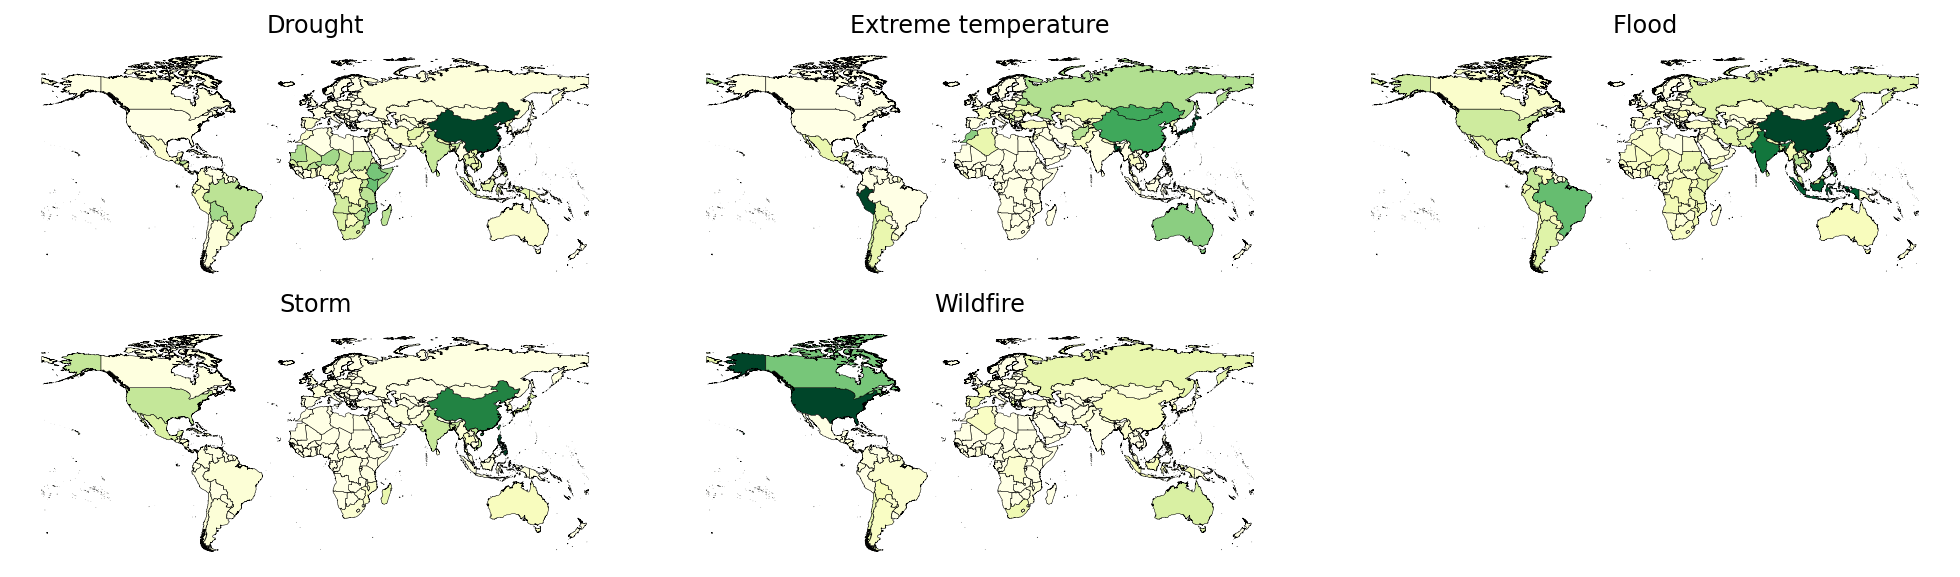

In [9]:
fig, ax = plt.subplots(3, 3, figsize=(14, 6), dpi=144)
for axis, disaster in zip_longest(fig.axes, disasters):    
    if disaster is None:
        axis.set_visible(False)
        continue
        
    disaster_2000s = df_prob.loc['2000':, [disaster]].groupby(level=0).sum()
    disaster_2000s = (disaster_2000s - disaster_2000s.mean()) / disaster_2000s.std()
    pd.merge(world, disaster_2000s, left_index=True, right_index=True).plot(disaster, ax=axis, cmap='YlGn', edgecolor='k', lw=0.25)
    axis.set_title(disaster)
    axis.axis('off')
fig.tight_layout()
plt.show()

# Networks

In [10]:
with warnings.catch_warnings(action='ignore'):
    # Make graph of bordering countires
    w1 = fuzzy_contiguity(world)
    
    # Robustness of statistics to choice of k?
    w2 = KNN.from_dataframe(world, k=2)    
    w = w_union(w1, w2)
    keys = sorted(list(w.neighbors.keys()))
    
    G = w.to_networkx().to_undirected()
    
    # Discard all but the main connected component (largest connected subgraph)
    G = nx.subgraph(G, list(nx.connected_components(G))[0])
    
    # Make a dataset of only the regions in the resulting graph
    connected_world = world.iloc[list(G.nodes)].copy()
    idx_to_name = dict(enumerate(keys))
    
    # Change node names from numbers to ISO codes and do a sanity check
    G = nx.relabel_nodes(G, idx_to_name)
    assert list(G['USA'].keys()) == ['CAN', 'MEX']
    
    
    # Compute the weight matrix resulting from the graph and do a sanity check
    w = W.from_networkx(G)
    w.remap_ids(list(G.nodes))
    assert w.neighbors['USA'] == ['CAN', 'MEX']

In [11]:
# Compute node positions for network graph (spring layout)
pos = nx.drawing.nx_pydot.graphviz_layout(G, 'neato')

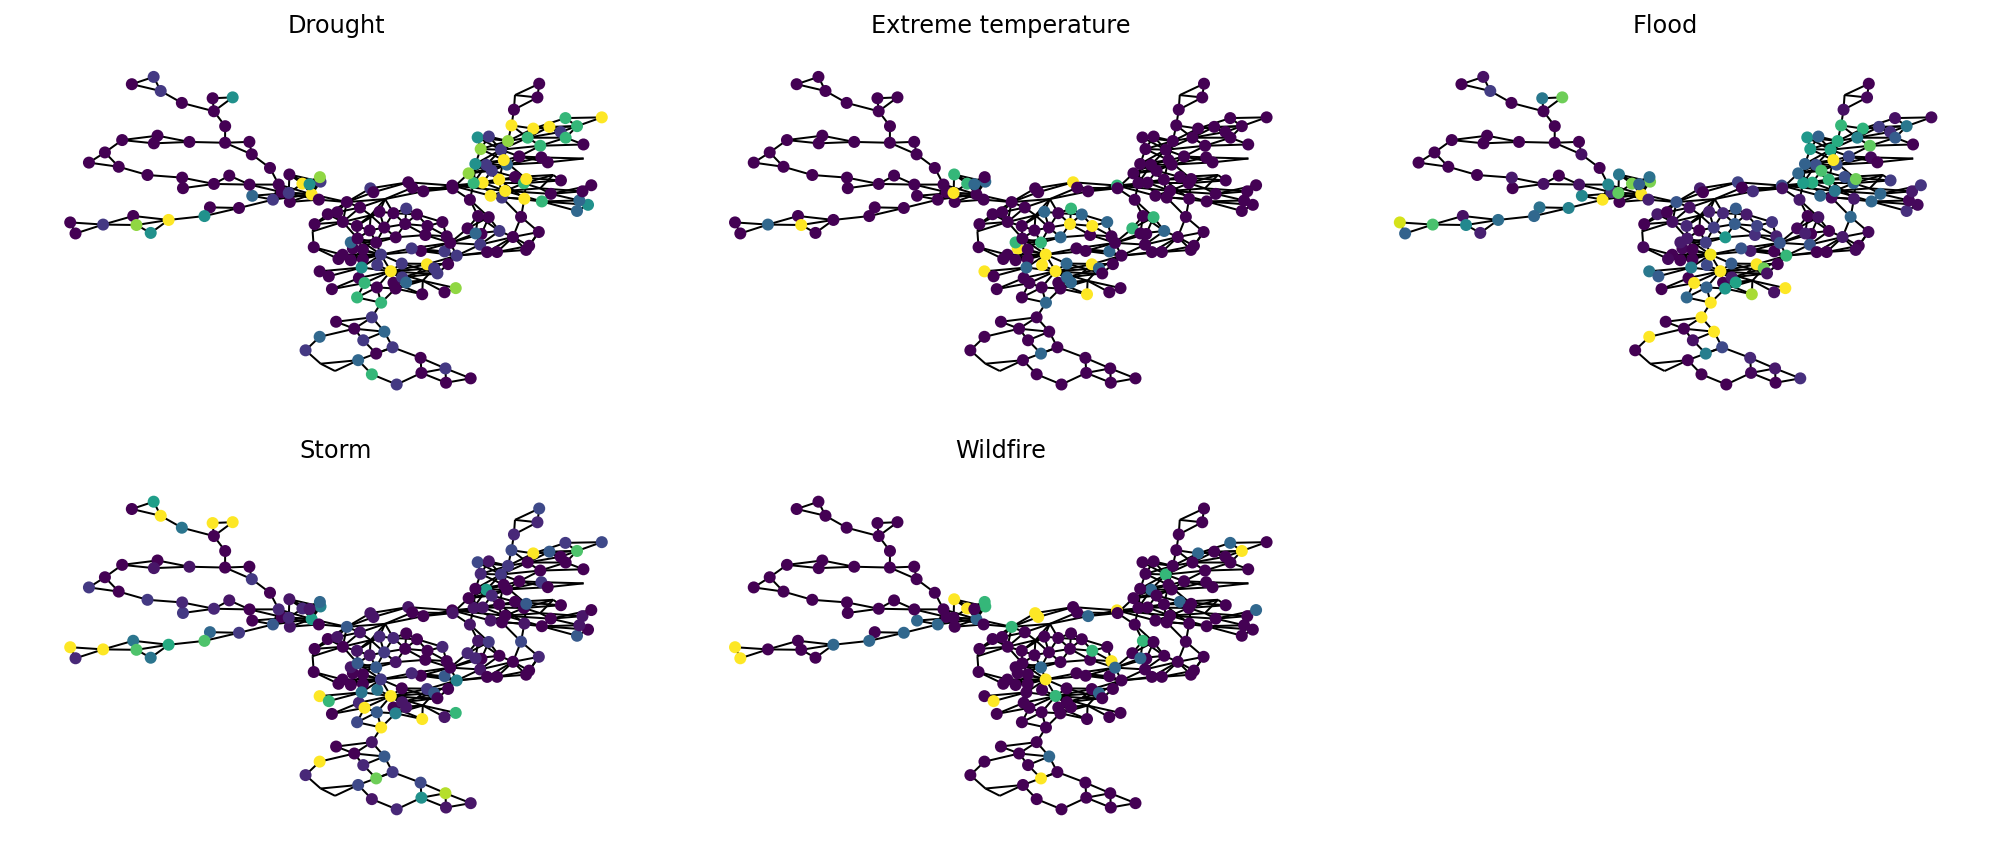

In [12]:
fig, ax = plt.subplots(3, 3, figsize=(14, 9), dpi=144)

for axis, disaster in zip_longest(fig.axes, df_prob):
    if disaster is None:
        axis.set_visible(False)
        continue
    
    merged_df = connected_world.join(df_prob.unstack(1).fillna(0)[disaster]) 
    
    node_data = merged_df.loc[:, years[-25:]].sum(axis=1)
    node_data = (node_data - node_data.mean()) / node_data.std()
    node_dict = node_data.to_dict()
    vmin, vmax = node_data.quantile([0.05, 0.95])
    
    nx.draw_networkx_nodes(G, pos, node_size=25, node_color=[node_dict.get(n) for n in G.nodes],
                           ax=axis,
                           vmin=vmin, vmax=vmax)
    nx.draw_networkx_edges(G, pos, ax=axis)
    axis.set_title(disaster)
    axis.axis('off')
fig.tight_layout()
plt.show()

# Spatial Autocorrelation (Moran's I)

### Sum since 2000

In [13]:
def get_stars(p):
    if p < 0.01:
        return '***'
    if p < 0.05:
        return '**'
    if p < 0.1: 
        return '*'
    return ''

In [14]:
print(f'{"Disaster":<22}{"Moran I":>15}{"P-value":>15}')
print('-'*60)
for disaster in disasters:
    merged_df = connected_world.join(df_prob.unstack(1).fillna(0)[disaster])
    node_data = merged_df.loc[:, years[-25:]].sum(axis=1)
    node_data = (node_data - node_data.mean()) / node_data.std()
    mi = Moran(node_data, w)
    print(f'{disaster:<20} {mi.I:>15.3f}{get_stars(mi.p_norm)}{mi.p_norm:>15.3f}')

Disaster                      Moran I        P-value
------------------------------------------------------------
Drought                       -0.021          0.758
Extreme temperature           -0.034          0.567
Flood                         -0.054          0.335
Storm                         -0.034          0.567
Wildfire                       0.012          0.731


### Year-by-year, full sample

In [15]:
corr_df = pd.DataFrame(np.nan, columns=df_prob.columns, index=years)
for disaster in disasters:
    merged_df = connected_world.join(df_prob.unstack(1).fillna(0)[disaster])
    for year in years:
        with warnings.catch_warnings(action='ignore'):
            mi = Moran(merged_df[year], w)
            corr_df.loc[year, disaster] = mi.I

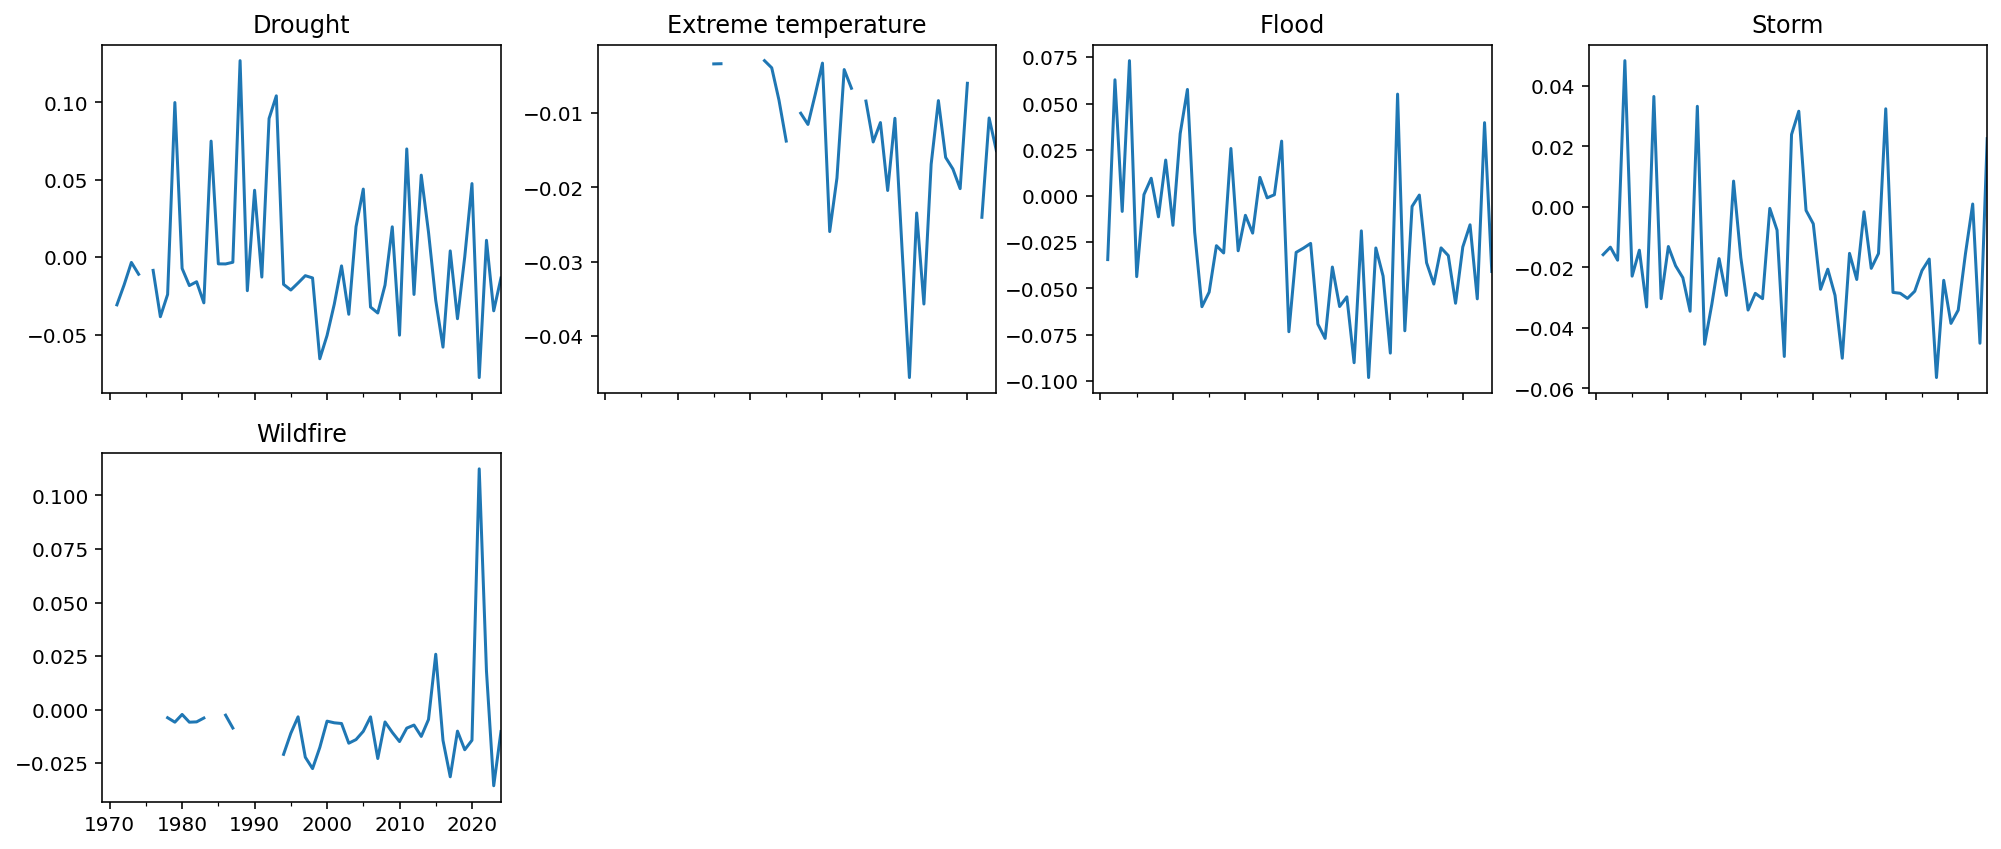

In [16]:
fig, ax = plt.subplots(2, 4, figsize=(14, 6), dpi=144, sharex=True)
for axis, disaster in zip_longest(fig.axes, disasters):
    if disaster is None:
        axis.set_visible(False)
        continue
    corr_df[disaster].plot(ax=axis)
    axis.set_title(disaster)
fig.tight_layout()
plt.show()

## Rolling 10-year average

In [17]:
corr_df = pd.DataFrame(np.nan, columns=df_prob.columns, index=years[10:])
for disaster in disasters:
    merged_df = (connected_world.join(df_prob.unstack(1).fillna(0)[disaster])
                     .loc[:, years]
                     .T)
    for start, stop in zip(years[:-10], years[10:]):
        with warnings.catch_warnings(action='ignore'):
            mi = Moran(merged_df.loc[start:stop].mean(), w)
            corr_df.loc[start, disaster] = mi.I

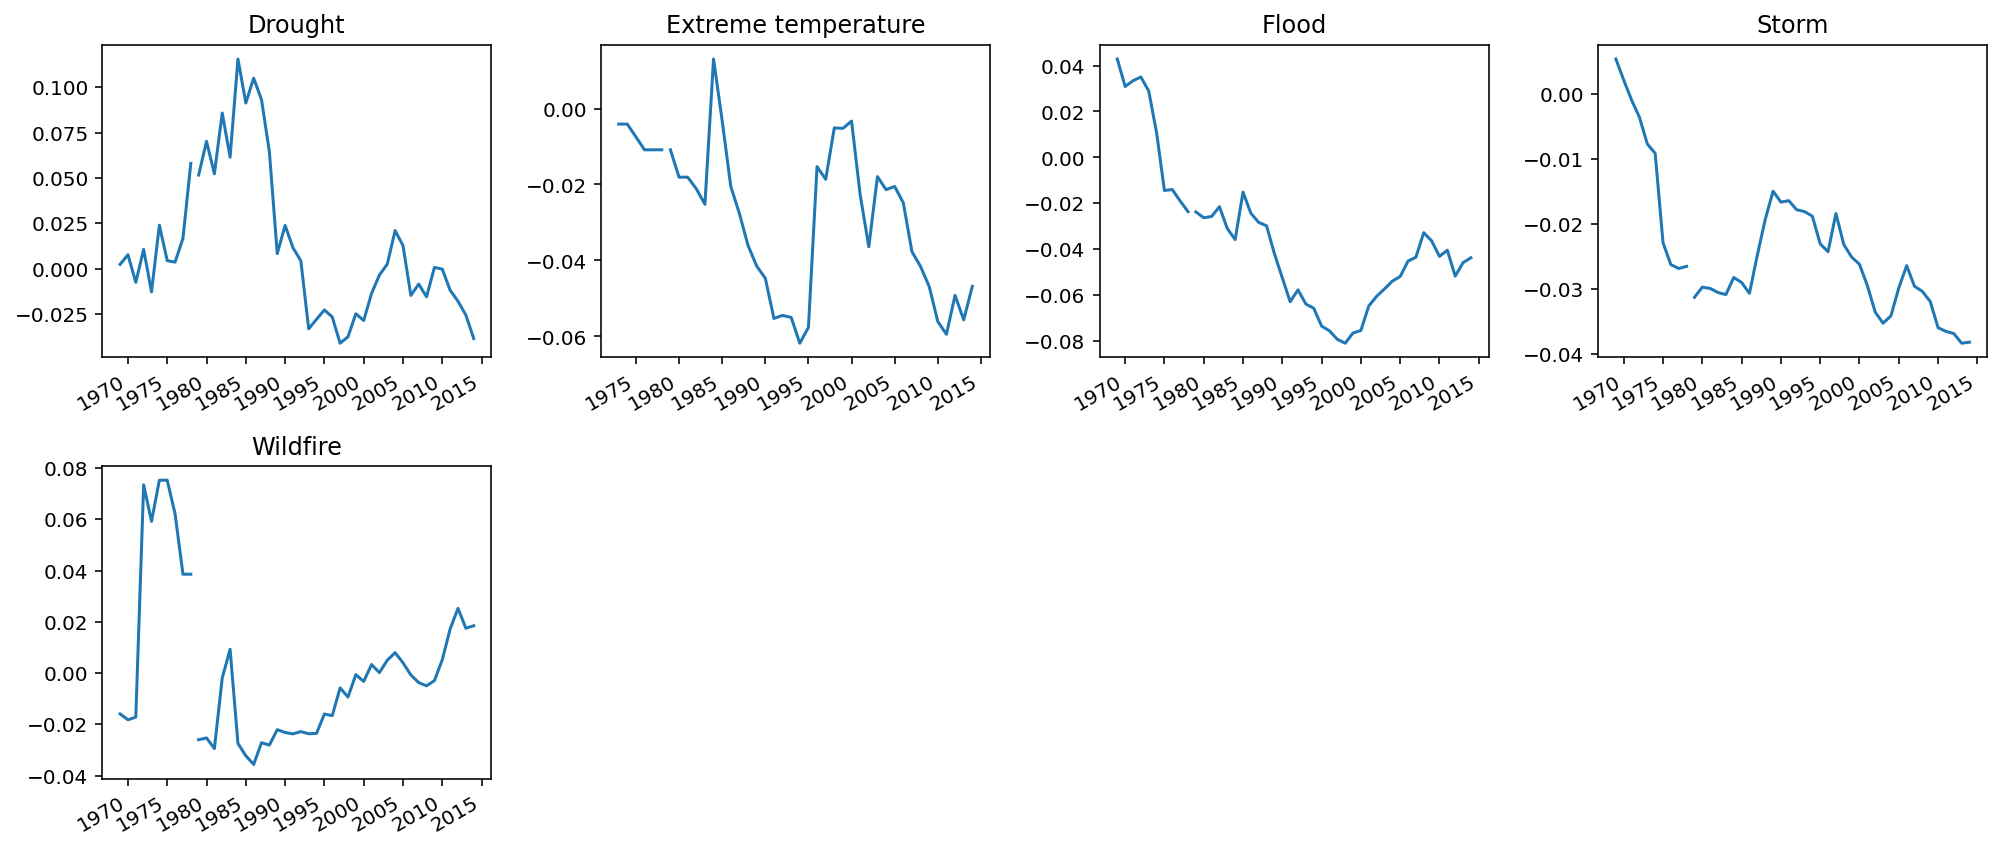

In [18]:
fig, ax = plt.subplots(2, 4, figsize=(14, 6), dpi=144)
for axis, disaster in zip_longest(fig.axes, disasters):
    if disaster is None:
        axis.set_visible(False)
        continue
    corr_df[disaster].plot(ax=axis)
    axis.set_title(disaster)
fig.tight_layout()
plt.show()

# Variograms

In [19]:
# !mamba install scikit-gstat -q -y
import skgstat as skg

In [20]:
centroids = (world.geometry
                 .to_crs('EPSG:3857')
                 .centroid
                 .apply(lambda x: pd.Series({'x':x.x, 'y':x.y}))
                 .mul(1e-3)) # convert meters to km

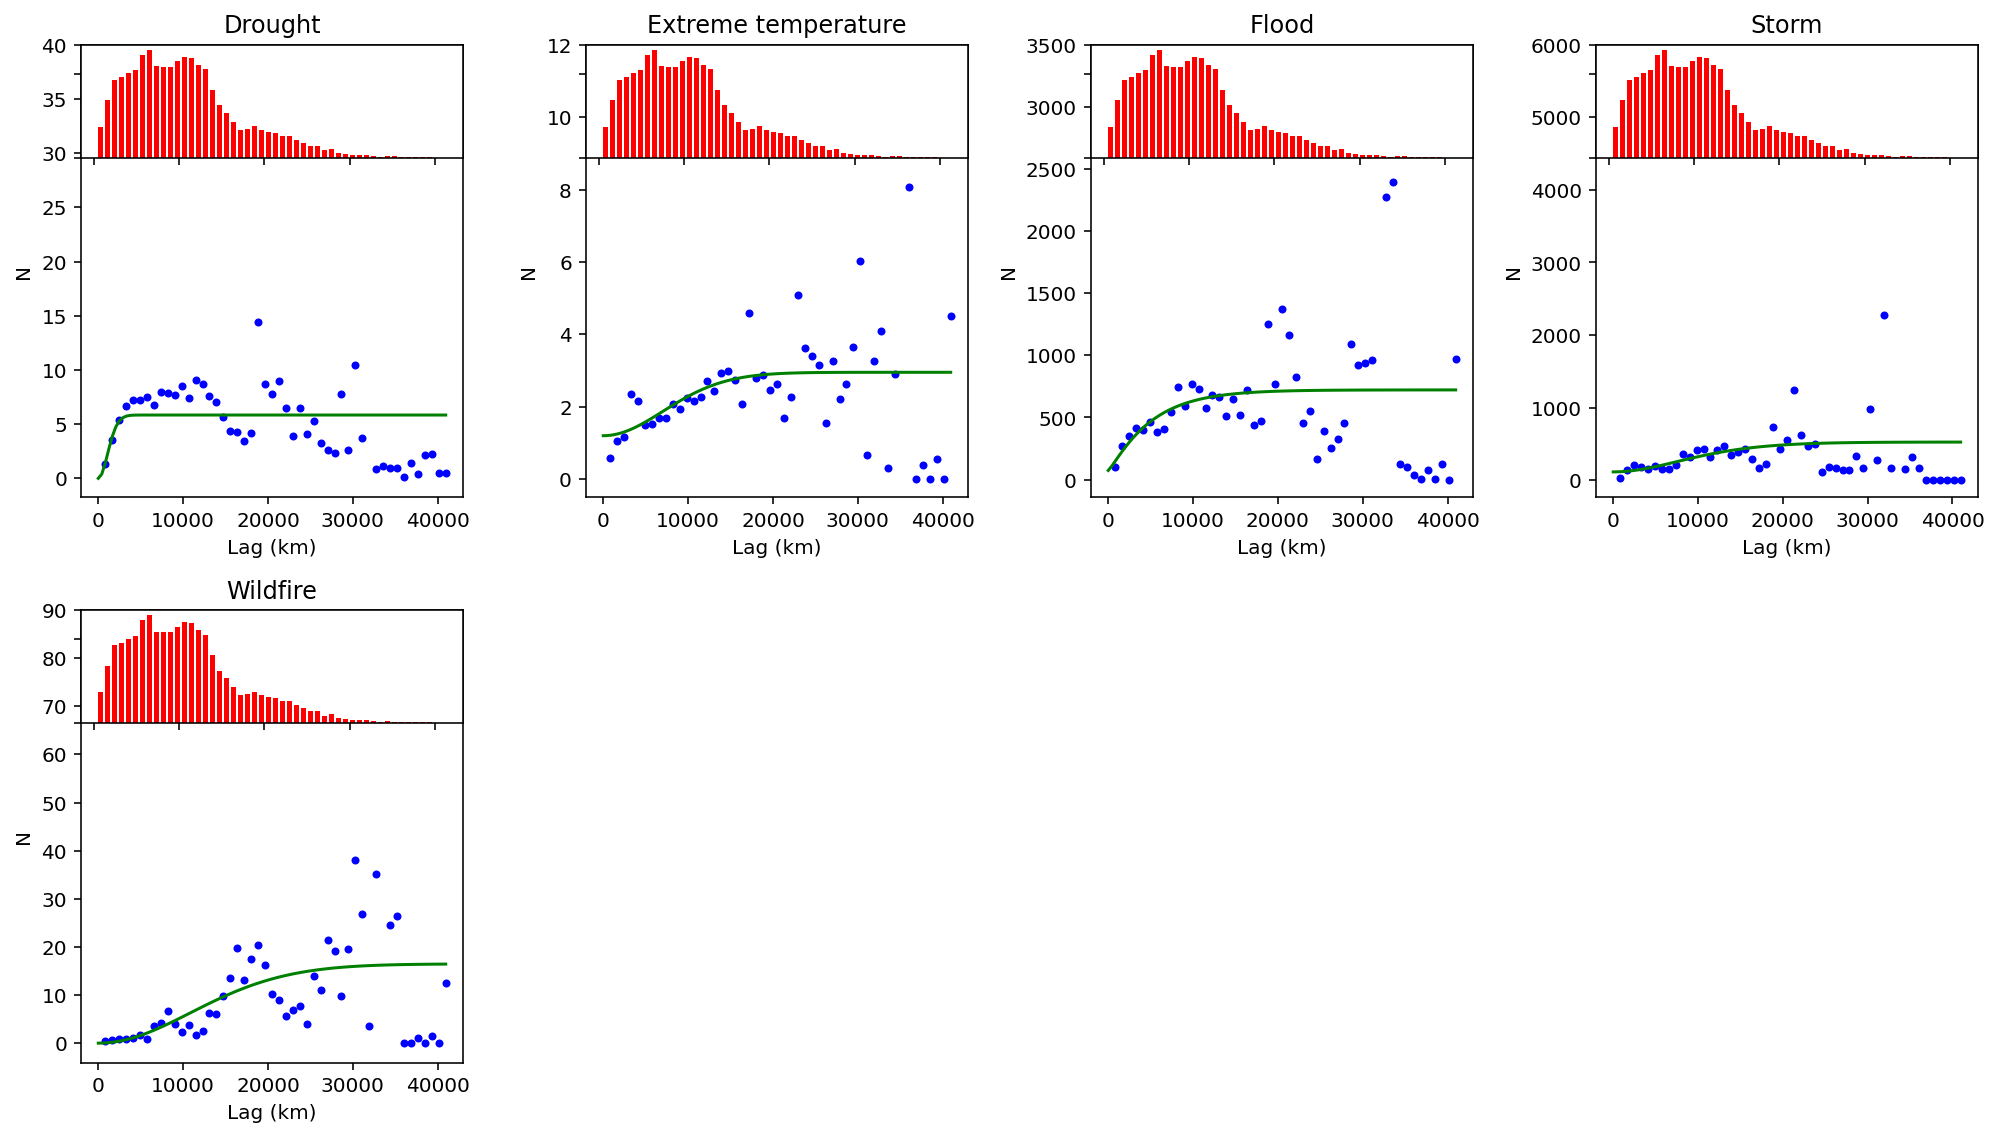

In [21]:
fig, ax = plt.subplots(2, 4, figsize=(14, 8), dpi=144)
for axis, disaster in zip_longest(fig.axes, disasters):
    if disaster is None:
        axis.set_visible(False)
        continue
    
    merged_df = (world.join(df_prob.unstack(1).fillna(0)[disaster])
                     .loc[:, years[-25:]]
                     .sum(axis=1))
    V = skg.Variogram(coordinates=centroids,
                      values=merged_df,
                      estimator='matheron',
                      dist_func='euclidean',
                      model='matern',
                      n_lags=50,
                      use_nugget=True)
    hist_ax = axis.inset_axes(bounds=[0, 0.75, 1.0, 0.25])
    V.plot(axes=[axis, hist_ax], show=False, grid=False)
    ticks = [x for x in hist_ax.xaxis.get_majorticklocs()]
    hist_ax.set_yticklabels([])
    hist_ax.set_xticklabels([])
    
    axis.set(title=disaster, xlabel = 'Lag (km)')
    axis.tick_params(axis='x', labelbottom=True)

    
fig.tight_layout()
plt.show()